<a href="https://colab.research.google.com/github/marrvinn/hareg-nlp/blob/master/05_modell_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import
Wordcloud und Transformer laufen nicht mehr im gleichen Environment

In [124]:
!pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.0.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.3.0
    Uninstalling Pillow-9.3.0:
      Successfully uninstalled Pillow-9.3.0


In [125]:
!pip install reportlab
!python -m spacy download de_core_news_sm
!pip install nltk
!python -m spacy download de_core_news_md
!pip install pyspellchecker
!pip install datasets
!pip install transformers
!pip install fonttools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 553 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44.4 MB 1.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

In [126]:
# Data
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
import datasets
from datasets import Dataset

# NLP
import regex as re
import spacy
from spellchecker import SpellChecker
from bs4 import SoupStrainer, BeautifulSoup
from bs4.element import Comment

# Modelling
from transformers import pipeline
import os
import torch
from torch import nn
from transformers import pipeline
from transformers import AutoTokenizer, BertTokenizer, DistilBertTokenizer
from transformers import AutoModelForSequenceClassification, RobertaForSequenceClassification
from transformers import BertForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import EarlyStoppingCallback
from tqdm import tqdm

# Evaluation
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# from wordcloud import WordCloud
import fontTools
import fontTools.subset

In [127]:
tqdm.pandas()
pd.options.mode.chained_assignment = None

In [128]:
# get traceback
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [129]:
torch.cuda.is_available()

True

In [130]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data

In [131]:
DB_CONNECT = "/content/drive/MyDrive/hareg_nlp/03_Data/hareg.db"
engine = sqlite3.connect(DB_CONNECT)
sql = '''SELECT* FROM df_firms'''
df = pd.read_sql(sql, engine)
df.head()

,name,regricht,regart,regnum,url,label,text,gegenstand,capital,website,zeichen
0,AUDI AG,Ingolstadt,HRB,1,https://www.audi.de/,Automotive,\nHandelsregister B des Abteilung B Nummer der...,"Entwicklung, Herstellung und Vertrieb von Kraf...","110080000,00","b'<!DOCTYPE html>\n<html lang=""de"" class=""nm-c...",179
1,Volkswagen AG,Wolfsburg,HRB,100484,https://www.volkswagen.de/,Automotive,\nHandelsregister B des Abteilung B Nummer der...,Gegenstand des Unternehmens ist die Herstellun...,"1283315873,28","b'\n\n\n\n<!DOCTYPE html>\n<html lang=""de"" dir...",551
2,ŠKODA AUTO Deutschland GmbH,Darmstadt,HRB,5242,https://www.skoda-auto.de/,Automotive,\nHandelsregister B des Abteilung B Nummer der...,Ist der Import und der Vertrieb von Fahrzeugen...,"2045200,00","b'<!DOCTYPE html>\n<html dir=""ltr"" lang=""de-D...",155
3,Tesla Germany GmbH,Berlin (Charlottenburg),HRB,235261,https://www.tesla.com/de_de/,Automotive,\n- Wiedergabe des aktuellen Registerinhalts -...,"Herstellung, Import, Vertrieb, Verkauf, Wartun...","25000,00","b'<!DOCTYPE html><html lang=""de-DE"" dir=""ltr"" ...",1074
4,BMW AG,München,HRB,42243,https://www.bmw.de/,Automotive,\nHandelsregister B des Abteilung B Nummer der...,Herstellung und Vertrieb von Motoren und damit...,"661399500,00","b'<!DOCTYPE HTML><html lang=""de-DE"" dir=""ltr"" ...",248


## Label

In [132]:
# dictionary mit label und integer als key
di_int_to_label = {0: 'Telecommunications',
                   1: 'Legal Services',
                   2: 'Management Consulting',
                   3: 'Medical Practice',
                   4: 'Consumer Goods',
                   5: 'Leisure, Travel & Tourism',
                   6: 'Recreational Facilities and Services',
                   7: 'Insurance',
                   8: 'Financial Services',
                   9: 'Real Estate',
                   10: 'Construction',
                   11: 'Automotive',
                   12: 'Marketing and Advertising',
                   13: 'Information Technology and Services',
                   14: 'Logistics and Supply Chain',
                   15: 'Wholesale',
                   16: 'Mechanical or Industrial Engineering',
                   17: 'Human Resources',
                   18: 'Renewables & Environment'}

In [133]:
# dictionary mit labelkeys als value und label als key
di_label_to_int = {'Telecommunications': 0,
                   'Legal Services': 1,
                   'Management Consulting': 2,
                   'Medical Practice': 3,
                   'Consumer Goods': 4,
                   'Leisure, Travel & Tourism': 5,
                   'Recreational Facilities and Services': 6,
                   'Insurance': 7,
                   'Financial Services': 8,
                   'Real Estate': 9,
                   'Construction': 10,
                   'Automotive': 11,
                   'Marketing and Advertising': 12,
                   'Information Technology and Services': 13,
                   'Logistics and Supply Chain': 14,
                   'Wholesale': 15,
                   'Mechanical or Industrial Engineering': 16,
                   'Human Resources': 17,
                   'Renewables & Environment': 18}

In [134]:
# change = di_int_to_label
change = di_label_to_int
df['label_int'] = df['label'].replace(change)

## Cleaning

In [135]:
df['gegenstand_raw'] = df['gegenstand']

In [136]:
# verbleibende Sonderzeichen ersetzen
def clean_txt(text):
  text = re.sub("'", "",text)
  text = re.sub("(\W)+"," ",text)
  return text

In [137]:
# Anzahl Wörter vor Verarbeitung
# Die maximal zulässige Inputsequenzlänge von 512 Tokens für BERT Modelle bei Klassifikation-Tasks wird nicht überschritten 
df['word_count'] = df['gegenstand'].str.split().apply(len)
df.word_count.describe()

count    114.000000
mean      61.114035
std       67.032915
min        3.000000
25%       22.000000
50%       42.000000
75%       71.750000
max      463.000000
Name: word_count, dtype: float64

In [138]:
df['gegenstand'] = df.gegenstand.apply(clean_txt)
df['label'] = df.label.replace(di_label_to_int)
df["tokens"] = ""

In [139]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train, valid = train_test_split(train, test_size=0.1, random_state=42, shuffle=True)

In [140]:
ds_train = Dataset.from_pandas(train)
ds_test = Dataset.from_pandas(test)
ds_valid = Dataset.from_pandas(valid)
di_data = datasets.DatasetDict({'train': ds_train, 'test': ds_test, 'valid': ds_valid})

## Spacy

Spacy StopWord Removal und (Lemmatization) trägt trotz Transformer Modell deutlich zur Verbesserung der Accuracy und F1 Scores bei.

In [141]:
# code 1:1 aus pds
nlp = spacy.load("de_core_news_sm", exclude=['tok2vec', 'tagger', 'morphologizer', 'parser', 'attribute_ruler', 'ner', 'senter'])

def opt_preprocess(text):
    remove_list = []

    doc = nlp(text.lower())
  
    non_stop_lem = [token.lemma_ for token in doc if not token.is_stop if not token.is_punct]

    for word in non_stop_lem:
        if re.findall('[^a-zA-Z0-9_À-ÖØ-öø-ÿ]', word):
            remove_list.append(word)

    return " ".join([word for word in non_stop_lem if word not in remove_list])

In [142]:
df['gegenstand'] = df.progress_apply(lambda row: opt_preprocess(row['gegenstand']), axis=1)

100%|██████████| 114/114 [00:00<00:00, 467.38it/s]


In [143]:
df['gegenstand'] = df.gegenstand.apply(lambda text: text.lower())

## Lemmatization (2)
Beim betrachten der Daten fällt auf, dass die Lemmatization nicht richtig funktioniert hat. Daher wird diese erneut durchgeführt.
Tatsächlich verschlechtert die korrekte Lemmatization die Vorhersagegenauigkeit um ~ 3% Accuracy/F1-Score. Daher wird diese nun doch nicht mehr ausgeführt.

In [144]:
nlp = spacy.load('de_core_news_md')

def lemma(text):
    doc = nlp(text.lower())
    text = " ".join(w.lemma_.lower() for w in doc) # if not w.is_stop if not w.is_punct)
    return text

In [145]:
# df['gegenstand'] = df.progress_apply(lambda row: lemma(row['gegenstand']), axis=1)

## Stop Words (2)

Erweiterete Stopword Liste führt erwartungsgemäß zu schlechteren Ergebnisse. Daher nur einzelne Buchstaben entfernen, was mit einem Regex im Nachhinein betrachtet wohl einfacher gewesen wäre. Doch das entfernen der Buchstaben führt ebenfalls zu signifikanten Einbußen. Die einzelnen Buchstaben sind höchstwahrscheinlich Gliederungspunkte. Der Transformer kann mit Hilfe dieser Punkte anscheinend den Zusammenhang der einzelnen Absätze besser konstruieren. Daher werden diese nun doch nicht entfernt. Wiederum verbessert die Entfernung einzelner Buchstaben aus dem Webseiten Text die Klassifikation.

In [146]:
# stopword liste von https://countwordsfree.com/stopwords/german
stopword_file = open("/content/drive/MyDrive/hareg_nlp/03_Data/stop_words_german.txt", "r")
stop_words_data = stopword_file.read()  
customize_stop_words = stop_words_data.replace('\n', ' ').split(" ")
stopword_file.close()
print(customize_stop_words)

['a', 'ab', 'aber', 'ach', 'acht', 'achte', 'achten', 'achter', 'achtes', 'ag', 'alle', 'allein', 'allem', 'allen', 'aller', 'allerdings', 'alles', 'allgemeinen', 'als', 'also', 'am', 'an', 'andere', 'anderen', 'andern', 'anders', 'au', 'auch', 'auf', 'aus', 'ausser', 'außer', 'ausserdem', 'außerdem', 'b', 'bald', 'bei', 'beide', 'beiden', 'beim', 'beispiel', 'bekannt', 'bereits', 'besonders', 'besser', 'besten', 'bin', 'bis', 'bisher', 'bist', 'c', 'd', 'da', 'dabei', 'dadurch', 'dafür', 'dagegen', 'daher', 'dahin', 'dahinter', 'damals', 'damit', 'danach', 'daneben', 'dank', 'dann', 'daran', 'darauf', 'daraus', 'darf', 'darfst', 'darin', 'darüber', 'darum', 'darunter', 'das', 'dasein', 'daselbst', 'dass', 'daß', 'dasselbe', 'davon', 'davor', 'dazu', 'dazwischen', 'dein', 'deine', 'deinem', 'deiner', 'dem', 'dementsprechend', 'demgegenüber', 'demgemäss', 'demgemäß', 'demselben', 'demzufolge', 'den', 'denen', 'denn', 'denselben', 'der', 'deren', 'derjenige', 'derjenigen', 'dermassen', '

In [147]:
li_letter = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [148]:
print(nlp.Defaults.stop_words)

{'zehnten', 'alle', 'hier', 'diesem', 'aus', 'gibt', 'magst', 'viertes', 'bis', 'diesen', 'gut', 'allgemeinen', 'ihm', 'können', 'war', 'wie', 'großer', 'einen', 'ein', 'also', 'daselbst', 'dementsprechend', 'kommen', 'dem', 'ehrlich', 'anders', 'siebentes', 'worden', 'des', 'indem', 'kleiner', 'macht', 'demgemäß', 'kleinen', 'darunter', 'deiner', 'wirst', 'tat', 'sein', 'jemandem', 'müsst', 'wer', 'beiden', 'nein', 'ja', 'wurde', 'sah', 'kleines', 'gekonnt', 'vierter', 'siebte', 'sehr', 'gute', 'her', 'mit', 'gern', 'ihnen', 'welchem', 'bereits', 'beispiel', 'leicht', 'satt', 'keiner', 'ganz', 'dieselben', 'darfst', 'mein', 'großes', 'sonst', 'ins', 'einer', 'jene', 'ihn', 'besser', 'keinem', 'zusammen', 'sollte', 'jemanden', 'vierte', 'ende', 'erst', 'ersten', 'jahren', 'oft', 'uhr', 'dein', 'niemandem', 'statt', 'ausserdem', 'habe', 'eigen', 'besonders', 'sollten', 'mehr', 'zeit', 'richtig', 'durch', 'dahinter', 'lieber', 'ach', 'meines', 'dadurch', 'wir', 'tagen', 'waren', 'darum',

In [149]:
nlp = spacy.load('de_core_news_md')

In [150]:
def remove_stop_words(text):

    # add custom stop words
    for word in customize_stop_words:
        lex = nlp.vocab[word]
        lex.is_stop = True

    lst=[]
    stopwords = nlp.Defaults.stop_words

    for w in text.split():
        if w.lower() not in stopwords:    #checking whether the word is not 
            lst.append(w)                    #present in the stopword list.

    new_text = ' '.join(lst)        
    return new_text

In [151]:
def remove_letter(text):
    
    # add custom stop words
    for word in li_letter:
        lex = nlp.vocab[word]
        lex.is_stop = True

    lst=[]
    stopwords = nlp.Defaults.stop_words

    for w in text.split():
        if w.lower() not in stopwords:    #checking whether the word is not 
            lst.append(w)                    #present in the stopword list.

    new_text = ' '.join(lst)        
    return new_text 

In [152]:
# df['gegenstand_wordcloud'] = df.progress_apply(lambda row: remove_stop_words(row['gegenstand']), axis=1)

## Spellchecker

In [153]:
spell = SpellChecker(language='de')

def spellcheck(text):
    text = text.split()
    # find those words that may be misspelled
    misspelled = spell.unknown(text)

    for word in misspelled:
        correction = spell.correction(word)
        # print(correction)
        text = [(w.replace(w, correction) if ((w == word) & (correction is not None)) else w) for w in text]
    
    print(text)
    text = " ".join(text)
    return text

In [154]:
text = "hier ist was fual udn es stimmt nohc mehr nihct"
spellcheck(text)

['hier', 'ist', 'was', 'faul', 'und', 'es', 'stimmt', 'noch', 'mehr', 'nicht']


'hier ist was faul und es stimmt noch mehr nicht'

Der Unternehmensgegenstand ist nahezu fehlerfrei. Daher neigt der Spellchecker zur Verschlimmbesserung und vermindert dadurch Accuracy und F1-Score.

In [155]:
# df['gegenstand'] = df.progress_apply(lambda row: spellcheck(row['gegenstand']), axis=1)

## Preprocessing Ideas

In [156]:
# noch nicht umgesetzte Ideen:
# zusammengesetzte nomen aufsplitten und sowohl die komponenten als auch das urspgl. nomen behalten
# n/bigrams
# enhance sentences
# einzelne englishe wörter nach deutsch Übersetzen

# für html - umlaute welche in html durch code dargestellt werden vor stop word removal wiederherstellen
# sieh dazu auch https://stackoverflow.com/questions/46613734/how-do-i-replace-xc3-etc-with-umlauts
# spellchekcer nutzen, um aus Versehen getrennte Worte nach utf-8 umlaut wieder zusammenzuführen

In [157]:
DB_CONNECT = '/content/drive/MyDrive/hareg_nlp/03_Data/hareg.db'
engine = sqlite3.connect(DB_CONNECT)
### df.to_sql('df_spellcheck', con=engine, if_exists='fail', index = False, chunksize=10000)

## Tokenization
try to train custom tokenizer 
https://www.youtube.com/watch?v=DJimQynXZsQ
https://www.youtube.com/watch?v=MR8tZm5ViWU&list=PLo2EIpI_JMQvWfQndUesu0nPBAtZ9gP1o&index=55

In [158]:
# distilbert-base-uncased
# tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_tok

In [159]:
# df['tokens'] = df['gegenstand'].apply(lambda row: tokenizer(row, padding='max_length', truncation=True))
def make_tokens(data):
    return tokenizer(data['text'], padding='max_length', truncation=True)

In [160]:
di_data = di_data.map(make_tokens, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [161]:
ds_train = di_data["train"]
ds_test = di_data["test"]
ds_valid = di_data["valid"]

## Class Weights

In [162]:
class_weights = (1- (train['label'].value_counts().sort_index()/len(train))).values
class_weights = torch.from_numpy(class_weights).float().to('cuda')
class_weights

tensor([0.9506, 0.9506, 0.9383, 0.9753, 0.9506, 0.9383, 0.9630, 0.9506, 0.9383,
        0.9259, 0.9630, 0.9506, 0.9630, 0.9383, 0.9259, 0.9506, 0.9383, 0.9506,
        0.9383], device='cuda:0')

# new distil-BERT

Vor der Klassifikation könnte zudem ein binäres Klassifikationsmodell eingesetzt werden, um Holding-Gesellschaften herauszufiltern.

## Fine-Tune 

In [163]:
# model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=19)
model = BertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=19)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Model config BertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dim": 768,
  "dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "

In [164]:
training_args = TrainingArguments(output_dir='trainer',
                                  evaluation_strategy='steps',
                                  eval_steps = 250,
                                  save_total_limit = 5,
                                  num_train_epochs=8,
                                  per_device_train_batch_size = 16,
                                  gradient_accumulation_steps = 2,
                                  logging_dir='./logs',
                                  logging_steps=1,
                                  metric_for_best_model = 'f1',
                                  load_best_model_at_end=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [165]:
# Trainer class from https://huggingface.co/docs/transformers/v4.24.0/en/main_classes/trainer#transformers.Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [166]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [167]:
trainer = CustomTrainer(model = model,
                        args = training_args, 
                        train_dataset = ds_train, 
                        eval_dataset = ds_valid, 
                        compute_metrics = compute_metrics,
                        tokenizer = tokenizer,
                        callbacks = [EarlyStoppingCallback(early_stopping_patience=3)])

In [168]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: regnum, website, url, tokens, regricht, capital, __index_level_0__, name, gegenstand, word_count, label_int, text, zeichen, gegenstand_raw, regart. If regnum, website, url, tokens, regricht, capital, __index_level_0__, name, gegenstand, word_count, label_int, text, zeichen, gegenstand_raw, regart are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 81
  Num Epochs = 8
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, dist

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=24, training_loss=2.980625649293264, metrics={'train_runtime': 60.5251, 'train_samples_per_second': 10.706, 'train_steps_per_second': 0.397, 'total_flos': 170521987719168.0, 'train_loss': 2.980625649293264, 'epoch': 8.0})

In [169]:
trainer.save_model("/content/drive/MyDrive/hareg_nlp/04_Models/dist_bert")

Saving model checkpoint to /content/drive/MyDrive/hareg_nlp/04_Models/dist_bert
Configuration saved in /content/drive/MyDrive/hareg_nlp/04_Models/dist_bert/config.json
Model weights saved in /content/drive/MyDrive/hareg_nlp/04_Models/dist_bert/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/hareg_nlp/04_Models/dist_bert/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/hareg_nlp/04_Models/dist_bert/special_tokens_map.json


In [239]:
# tokenized input
# ds_train[0]

In [240]:
# show hidden embedding
# model.bert.embeddings.word_embeddings.weight

## Predict

In [172]:
path = "/content/drive/MyDrive/hareg_nlp/04_Models/dist_bert"

pipe = pipeline('text-classification',
    model=path,
    device=0,
    truncation=True)

loading configuration file /content/drive/MyDrive/hareg_nlp/04_Models/dist_bert/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/hareg_nlp/04_Models/dist_bert",
  "activation": "gelu",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dim": 768,
  "dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
  

In [173]:
test['label_pred'] = test.progress_apply(lambda row: pipe(row['gegenstand'])[0]['label'].replace('LABEL_',''), axis=1)
test.label_pred = test.label_pred.astype(int)

 48%|████▊     | 11/23 [00:00<00:00, 51.00it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 23/23 [00:00<00:00, 53.41it/s]


## Evaluate

In [174]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: regnum, website, url, tokens, regricht, capital, __index_level_0__, name, gegenstand, word_count, label_int, text, zeichen, gegenstand_raw, regart. If regnum, website, url, tokens, regricht, capital, __index_level_0__, name, gegenstand, word_count, label_int, text, zeichen, gegenstand_raw, regart are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 3.120272636413574,
 'eval_accuracy': 0.0,
 'eval_f1': 0.0,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_runtime': 0.3212,
 'eval_samples_per_second': 31.129,
 'eval_steps_per_second': 6.226,
 'epoch': 8.0}

In [175]:
y_true = test['label']
y_pred = test['label_pred']

accuracy = balanced_accuracy_score(y_true, y_pred)
f1_metric = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("Balanced Accuracy: {:.4f}".format(accuracy))
print("F1-score: {:.4f}".format(f1_metric))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

Balanced Accuracy: 0.0000
F1-score: 0.0000
Precision: 0.0000
Recall: 0.0000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# new ger-BERT

## Fine-Tune

In [176]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-german-cased', num_labels=19)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-german-cased/snapshots/06b1dc5ba050ddbf462d060df38f906eedb31b01/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-german-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 

In [177]:
trainer = CustomTrainer(model = model,
                        args = training_args, 
                        train_dataset = ds_train, 
                        eval_dataset = ds_valid, 
                        compute_metrics = compute_metrics,
                        tokenizer = tokenizer,
                        callbacks = [EarlyStoppingCallback(early_stopping_patience=3)])

In [178]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: regnum, website, url, tokens, regricht, capital, __index_level_0__, name, gegenstand, word_count, label_int, text, zeichen, gegenstand_raw, regart. If regnum, website, url, tokens, regricht, capital, __index_level_0__, name, gegenstand, word_count, label_int, text, zeichen, gegenstand_raw, regart are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 81
  Num Epochs = 8
  Instantaneous batch size per device = 16
  Total train batch size (w. pa

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=24, training_loss=2.9219478964805603, metrics={'train_runtime': 31.1784, 'train_samples_per_second': 20.784, 'train_steps_per_second': 0.77, 'total_flos': 85864898174976.0, 'train_loss': 2.9219478964805603, 'epoch': 8.0})

In [179]:
trainer.save_model("/content/drive/MyDrive/hareg_nlp/04_Models/ger_bert")

Saving model checkpoint to /content/drive/MyDrive/hareg_nlp/04_Models/ger_bert
Configuration saved in /content/drive/MyDrive/hareg_nlp/04_Models/ger_bert/config.json
Model weights saved in /content/drive/MyDrive/hareg_nlp/04_Models/ger_bert/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/hareg_nlp/04_Models/ger_bert/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/hareg_nlp/04_Models/ger_bert/special_tokens_map.json


## Predict

In [180]:
path = "/content/drive/MyDrive/hareg_nlp/04_Models/ger_bert"

pipe = pipeline('text-classification',
    model=path,
    device=0,
    truncation=True)

loading configuration file /content/drive/MyDrive/hareg_nlp/04_Models/ger_bert/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/hareg_nlp/04_Models/ger_bert",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    "LABEL_15": 15,
    "LABEL

In [181]:
test['label_pred'] = test.progress_apply(lambda row: pipe(row['gegenstand'])[0]['label'].replace('LABEL_',''), axis=1)
test.label_pred = test.label_pred.astype(int)

 35%|███▍      | 8/23 [00:00<00:00, 75.19it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 23/23 [00:00<00:00, 81.57it/s]


## Evaluate

In [182]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: regnum, website, url, tokens, regricht, capital, __index_level_0__, name, gegenstand, word_count, label_int, text, zeichen, gegenstand_raw, regart. If regnum, website, url, tokens, regricht, capital, __index_level_0__, name, gegenstand, word_count, label_int, text, zeichen, gegenstand_raw, regart are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 3.1117424964904785,
 'eval_accuracy': 0.0,
 'eval_f1': 0.0,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_runtime': 0.1733,
 'eval_samples_per_second': 57.71,
 'eval_steps_per_second': 11.542,
 'epoch': 8.0}

In [183]:
y_true = test['label']
y_pred = test['label_pred']

accuracy = balanced_accuracy_score(y_true, y_pred)
f1_metric = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("Accuracy: {:.4f}".format(accuracy))
print("F1-score: {:.4f}".format(f1_metric))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy: 0.0000
F1-score: 0.0000
Precision: 0.0000
Recall: 0.0000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# old distil-BERT

In [184]:
path_old_model = "/content/drive/MyDrive/capstoneproject/models/transformer/distilbert_overlap_chunking_checkpoint-2500"

## Single Predictions

In [185]:
def old_predict(txt_input):
    pipe = pipeline('text-classification',
                    model=path_old_model,
                    device=0,
                    truncation=True
                    )
    model_output = pipe(txt_input)
    label_id = int(model_output[0]['label'].replace('LABEL_',''))
    score = model_output[0]['score']*100
    score = float("{:.2f}".format(score))
    label = di_int_to_label[label_id]
    
    return label, score

In [186]:
try_input = df.loc[100, "gegenstand"]
print(old_predict(try_input),"\n",try_input)

loading configuration file /content/drive/MyDrive/capstoneproject/models/transformer/distilbert_overlap_chunking_checkpoint-2500/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/capstoneproject/models/transformer/distilbert_overlap_chunking_checkpoint-2500",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL

('Renewables & Environment', 48.57) 
 gegenstand gesellschaft forschung maßnahmen initiativen sicherung klimasituation verbesserung umwelt energieeinsparung zweck gesellschaft förderung wissenschaft forschung weiterbildung umweltschutzes aufgabe arbeitsgebieten schnittstelle wissenschaftlicher erkenntnissuche praktischer umsetzung tätig forschungsergebnisse strategien initiativen schutz klima umwelt umzusetzen leistungsfähigkeit wissenschaftlichen ansprüchen genügen


In [187]:
pipe_old = pipeline('text-classification',
           model=path_old_model,
           device=0,
           truncation=True)

loading configuration file /content/drive/MyDrive/capstoneproject/models/transformer/distilbert_overlap_chunking_checkpoint-2500/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/capstoneproject/models/transformer/distilbert_overlap_chunking_checkpoint-2500",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL

## Test Sample

In [188]:
test['label_pred'] = ""
test['label_pred'] = test.progress_apply(lambda row: pipe_old(row['gegenstand'])[0]['label'].replace('LABEL_',''), axis=1)
test.label_pred = test.label_pred.astype(int)

 39%|███▉      | 9/23 [00:00<00:00, 85.61it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 23/23 [00:00<00:00, 80.71it/s]


In [189]:
y_true = test['label']
y_pred = test['label_pred']

accuracy = balanced_accuracy_score(y_true, y_pred)
f1_metric = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("Accuracy: {:.4f}".format(accuracy))
print("F1-score: {:.4f}".format(f1_metric))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

Accuracy: 0.5111
F1-score: 0.6406
Precision: 0.6957
Recall: 0.6087


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Whole Sample

In [190]:
df_all = df

In [191]:
df_all['label_pred'] = ""
df_all['label_pred'] = df_all.progress_apply(lambda row: pipe_old(row['gegenstand'])[0]['label'].replace('LABEL_',''), axis=1)
df_all.label_pred = df_all.label_pred.astype(int)

  0%|          | 0/114 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 114/114 [00:00<00:00, 118.13it/s]


In [192]:
y_true = df_all['label']
y_pred = df_all['label_pred']

# average = weighted -> impliziert accuracy = recall
accuracy = balanced_accuracy_score(y_true, y_pred)
f1_metric = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("Accuracy: {:.4f}".format(accuracy))
print("F1-score: {:.4f}".format(f1_metric))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

Accuracy: 0.6316
F1-score: 0.5995
Precision: 0.6523
Recall: 0.6316


### Classification Report

In [193]:
df_all['label_pred_txt'] = df_all['label_pred'].replace(di_int_to_label)

change = di_int_to_label
# change = di_label_to_int
df_all['label_pred'] = df_all['label_pred'].replace(change)
df_all['label'] = df_all['label'].replace(change)

In [194]:
print(classification_report(df_all['label'].to_list(), df_all['label_pred'].to_list()))

                                      precision    recall  f1-score   support

                          Automotive       0.62      0.83      0.71         6
                        Construction       0.80      0.67      0.73         6
                      Consumer Goods       0.00      0.00      0.00         6
                  Financial Services       1.00      0.83      0.91         6
                     Human Resources       1.00      0.17      0.29         6
 Information Technology and Services       0.56      0.83      0.67         6
                           Insurance       1.00      1.00      1.00         6
                      Legal Services       0.67      0.67      0.67         6
           Leisure, Travel & Tourism       0.50      0.17      0.25         6
          Logistics and Supply Chain       0.71      0.83      0.77         6
               Management Consulting       0.38      0.83      0.53         6
           Marketing and Advertising       0.60      1.00      

### Confusion Matrix

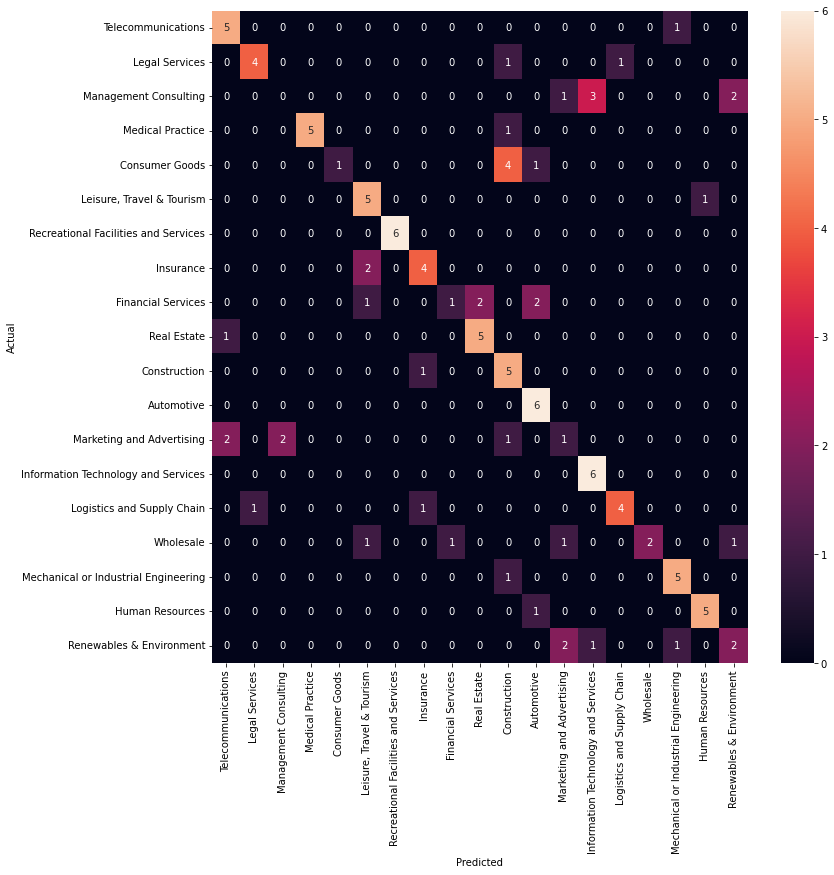

In [195]:
labels = list(di_int_to_label.values())
fig, ax = plt.subplots(figsize=(12,12)) 
cm = confusion_matrix(df_all['label'], df_all['label_pred'] )
f = sns.heatmap(cm, annot=True, fmt='d', linewidths=0.0, xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('cm_whole.svg', bbox_inches='tight',
            dpi=300)


In [196]:
labels = list(di_int_to_label.values())
cm = confusion_matrix(df_all['label'], df_all['label_pred'])
cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100

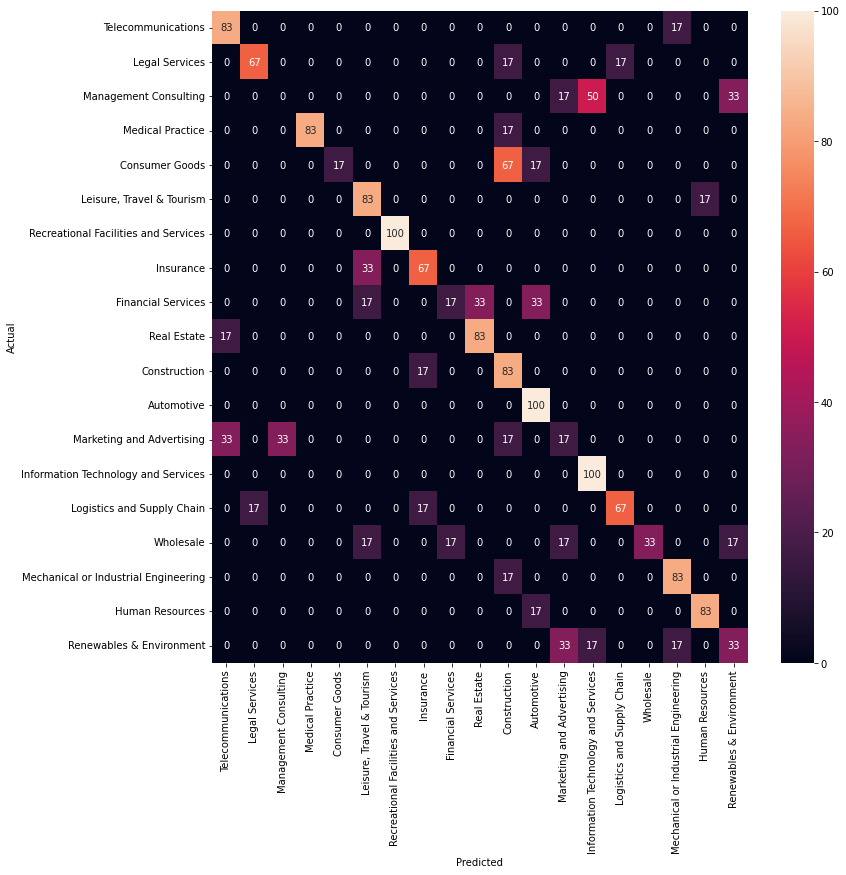

In [197]:
fig, ax = plt.subplots(figsize=(12,12))

f = sns.heatmap(cmn, annot=True, fmt='.0f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('cm_whole_relative.svg', bbox_inches='tight')

## Whole Sample Only Long
Durch die EDA wissen wir, dass die durchschnittliche Anzahl Zeichen ~520 beträgt. Der Median liegt bei ~344. Es existieren also viele Texte die kürzer als der Durchnittswert sind, aber auch einige lange Texte, welche die Verteilung positiv verzerren (positively skewed).
Wir filtern willkürlich bei einem Wert leicht unterhalb des Medians und beobachten, dass sowohl Accuracy als auch F1-Score um gut 7 bis 8 Prozentpunkte ansteigen.


In [198]:
df_long = df.loc[(df_all["zeichen"] >= 300)]
df_long.describe()

,zeichen,label_int,word_count
count,65.000000,65.000000,65.000000
mean,780.707692,8.876923,91.523077
std,629.717216,5.663777,75.427761
min,303.000000,0.000000,31.000000
25%,420.000000,3.000000,50.000000
50%,582.000000,9.000000,69.000000
75%,817.000000,14.000000,89.000000
max,3907.000000,18.000000,463.000000


In [199]:
df_long['label_pred'] = ""
df_long['label_pred'] = df_long.progress_apply(lambda row: pipe_old(row['gegenstand'])[0]['label'].replace('LABEL_',''), axis=1)
df_long.label_pred = df_long.label_pred.astype(int)

  0%|          | 0/65 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 65/65 [00:00<00:00, 122.22it/s]


In [200]:
df_long['label_pred_txt'] = df_long['label_pred'].replace(di_int_to_label)

# change = di_int_to_label
change = di_label_to_int
df_long['label_pred'] = df_long['label_pred'].replace(change)
df_long['label'] = df_long['label'].replace(change)

In [201]:
y_true = df_long['label']
y_pred = df_long['label_pred']

accuracy = balanced_accuracy_score(y_true, y_pred)
f1_metric = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("Accuracy: {:.4f}".format(accuracy))
print("F1-score: {:.4f}".format(f1_metric))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

Accuracy: 0.6667
F1-score: 0.6694
Precision: 0.7497
Recall: 0.6769


### Class Report

In [202]:
df_long['label_pred_txt'] = df_long['label_pred'].replace(di_int_to_label)

change = di_int_to_label
# change = di_label_to_int
df_long['label_pred'] = df_long['label_pred'].replace(change)
df_long['label'] = df_long['label'].replace(change)

In [203]:
print(classification_report(df_long['label'].to_list(), df_long['label_pred'].to_list()))

                                      precision    recall  f1-score   support

                          Automotive       0.50      0.67      0.57         3
                        Construction       0.67      1.00      0.80         2
                      Consumer Goods       0.00      0.00      0.00         2
                  Financial Services       1.00      0.80      0.89         5
                     Human Resources       1.00      0.50      0.67         2
 Information Technology and Services       0.50      0.67      0.57         3
                           Insurance       1.00      1.00      1.00         4
                      Legal Services       1.00      0.67      0.80         6
           Leisure, Travel & Tourism       1.00      0.50      0.67         2
          Logistics and Supply Chain       1.00      1.00      1.00         3
               Management Consulting       0.50      1.00      0.67         2
           Marketing and Advertising       0.50      1.00      

### Conf Matrix

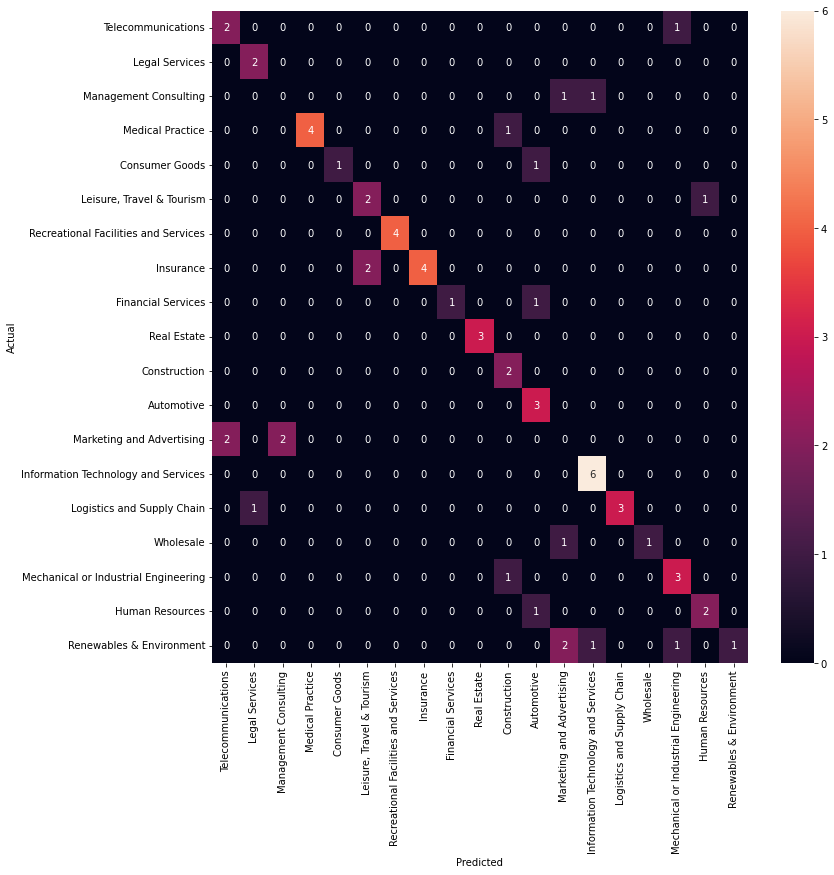

In [204]:
labels = list(di_int_to_label.values())
fig, ax = plt.subplots(figsize=(12,12)) 
cm = confusion_matrix(df_long['label'], df_long['label_pred'] )
f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('cm_whole_long.svg', bbox_inches='tight',
            dpi=300)

In [205]:
labels = list(di_int_to_label.values())
cm = confusion_matrix(df_long['label'], df_long['label_pred'])
cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100

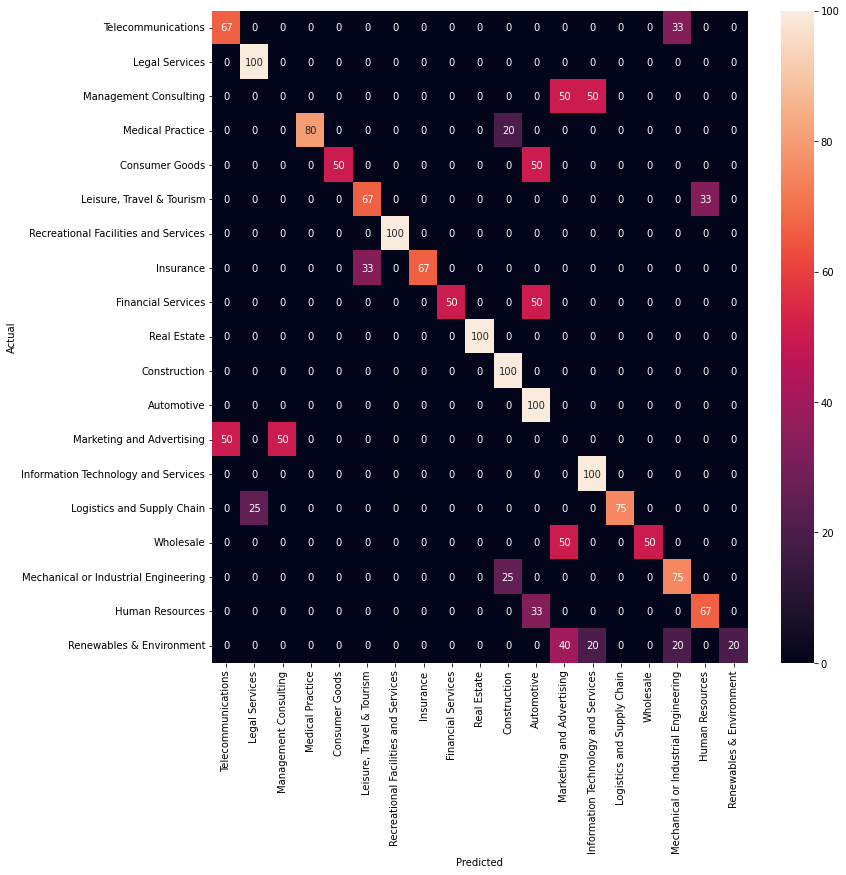

In [206]:
fig, ax = plt.subplots(figsize=(12,12))
f = sns.heatmap(cmn, annot=True, fmt='.0f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('cm_whole_long_relative.svg', bbox_inches='tight')

# Website Classifier

### Parsen

In [207]:
# code zu tag_visible und extract_text aus pds
def tag_visible(element):
  if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
      return False
  if isinstance(element, Comment):
      return False
  return True

def extract_text(raw_html):
  raw_text = ''
  description = ''
  keywords = ''

  try:
    soup = BeautifulSoup(raw_html, 'lxml')
    #text
    text = soup.find_all(text=True)
    visible_texts = filter(tag_visible, text)
    text = u"°".join(t.strip() for t in visible_texts)
    raw_text = re.sub(r"(\s\s)+", " ", text)
  except:
    pass
    
  #meta
  try:
    description = soup.find("meta", attrs={'name': 'description'})['content']
  except:
    try:
      description = soup.find("meta", property="og:description")['content']
    except:
      pass
  try:
    keywords = soup.find("meta", attrs={'name': 'keywords'})['content']
  except:
    pass


  return raw_text, description, keywords

In [208]:
df[['site_text', 'description', 'keywords']] = df.progress_apply(lambda row: extract_text(row['website']), axis=1, result_type='expand')

100%|██████████| 114/114 [00:04<00:00, 22.82it/s]


### Decode UTF-8
Wrd aktuell nicht benötigt, die strings enthalten non ascii letter, daher ist die Dekodierung der Umlaute nicht ohne weiteres umzusetzen

In [209]:
# zur besseren Verarbeitung schon mal bestimmte Sonderzeichen entfernen
def clean_ascii(text):
    text = re.sub('°', ' ', str(text))
    text = re.sub("b' ", '', str(text))
    text = str(text).replace('\\\\', '\\')
    text = text.replace(':', '')
    return text

In [210]:
s = df.loc[4, "site_text"] 
bs = s.encode('raw-unicode-escape')  # encode to bytes without double-encoding
print(bs)

b"b'\xb0HTML\xb0Ihr Browser ist veraltet und m\\xc3\\xb6glicherweise nicht kompatibel mit unserer Website.\xb0Bitte wechseln Sie zu einem anderen Browser, z.B.\xb0Chrome\xb0,\xb0Firefox\xb0oder\xb0Safari\xb0.\xb0Schlie\\xc3\\x9fen\xb0Login MyBMW\xb0BMW Shop\xb0Modelle\xb0Beratung & Kauf\xb0Elektromobilit\\xc3\\xa4t\xb0Services\xb0Entdecken\xb0Suche\xb0BMW Partner finden\xb0Login MyBMW\xb0BMW Shop\xb0Freude\xb0am Fahren\xb0Willkommen bei MyBMW\xb0Registrieren Sie sich und nutzen Sie die Vorteile:\xb0Speichern Sie Ihre Fahrzeuge und Konfigurationen.\xb0Buchen und nutzen Sie Connected Drive Online-Dienste.\xb0Pflegen Sie Ihre Profildaten.\xb0Login\xb0Jetzt registrieren\xb0Willkommen, {firstName}\xb0Willkommen, {firstName}\xb0Logout\xb0Modelle\xb0Alle\xb0i\xb0X\xb0M\xb08er\xb07er\xb06er\xb05er\xb04er\xb03er\xb02er\xb01er\xb0Z\xb0Plug-in-Hybrid\xb0Concept Cars\xb0Limousine\xb0Touring\xb0Coup\\xc3\\xa9\xb0Cabrio / Roadster\xb0Sports Activity Vehicle\xb0Sports Activity Coup\\xc3\\xa9\xb0Gran 

In [211]:
s = 'und m\xc3\xb6glicherweise'
bs = s.encode('raw-unicode-escape')  # encode to bytes without double-encoding
print(bs)


b'und m\xc3\xb6glicherweise'


In [212]:
decoded = bs.decode('utf-8')
print(decoded)

und möglicherweise


### Cleanen

In [213]:
df['full_text'] = df['site_text'] + ' ' + df['description'] + ' ' + df['keywords']
df['full_text_raw'] = df['site_text'] + ' ' + df['description'] + ' ' + df['keywords']

In [214]:
def clean(text):
    text = text.replace('\n',' ')
    text = text.replace('\\n',' ')
    text = text.replace('html','')
    text = re.sub('°', ' ', str(text))
    text = re.sub('  ', ' ', str(text))
    text = re.sub(',+', ',', str(text))
    text = re.sub("'", "", str(text))
    text = re.sub("\b(\w)\b", "", str(text))
    return text

In [215]:
def remove_words(text, char_list):
    flag = 0
    in_list = text.split()
    new_list = []
    for line in in_list:
        new_words = ' '.join([word for word in line.split() if not any([phrase in word for phrase in char_list])])
        new_list.append(new_words)
        new_text = " ".join(new_list)
        flag = 1
    if flag == 1:
        return new_text
    else:
        return text

In [216]:
def clean_sonderzeichen(text):
    text = re.sub("(\W)+", " ", str(text))
    return text

In [217]:
def remove_special_words(text):
    text = text.replace('inkl','')
    text = text.replace('mwst','')
    return text

In [218]:
# allmögliches
df['full_text'] = df['full_text'].apply(lambda row: clean(row))

In [219]:
# remove words die bestimmte Sonderzeichen enthalten
char_list = ["\\", "{", "1", "2", "3",  "4",  "5",  "6",  "7",  "8",  "9", "0"]
df['full_text'] = df['full_text'].progress_apply(lambda row: remove_words(row, char_list))

100%|██████████| 114/114 [00:03<00:00, 29.75it/s]


In [220]:
# remove alle speziellen Zeichen und Zahlen
df['full_text'] = df['full_text'].apply(lambda row: clean_sonderzeichen(row))

In [221]:
# angepasstes preprocessing
df['full_text'] = df.progress_apply(lambda row: opt_preprocess(row['full_text']), axis=1)

100%|██████████| 114/114 [00:17<00:00,  6.53it/s]


In [222]:
# tolowercase oder Funktion lemma mit Lemmatizing nutzen
# lemmatizing verbessert F1-Score um 0,01 Prozentpunkte
df['full_text'] = df.full_text.apply(lambda text: text.lower())
df['full_text'] = df.full_text.progress_apply(lambda text: lemma(text)) 

100%|██████████| 114/114 [00:09<00:00, 11.63it/s]


In [223]:
# einzelne letter entfernen
df['full_text'] = df.progress_apply(lambda row: remove_letter(row['full_text']), axis=1)

100%|██████████| 114/114 [00:00<00:00, 5433.53it/s]


In [224]:
# einzelne letter entfernen (2), weil nach (1) immernoch einzelne letter enthalten sind
def kill_single_letter(text):

    new_text = ' '.join( [w for w in text.split() if len(w)>1] )

    return new_text

df['full_text'] = df.progress_apply(lambda row: kill_single_letter(row['full_text']), axis=1)

100%|██████████| 114/114 [00:00<00:00, 7869.89it/s]


In [225]:
# final strip
df['full_text'] = df.full_text.progress_apply(lambda text: re.sub(' +', ' ', text)) 

100%|██████████| 114/114 [00:00<00:00, 5015.11it/s]


In [226]:
# remove special words
# df['full_text'] = df.full_text.progress_apply(lambda text: remove_special_words(text)) 
# !besser nicht, haben Aussagekraft

## Classify Website

In [227]:
df['web_pred'] = df.progress_apply(lambda row: pipe_old(row['full_text'])[0]['label'].replace('LABEL_',''), axis=1)
df['web_pred'] = df['web_pred'].astype(int)

  0%|          | 0/114 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 114/114 [00:02<00:00, 55.15it/s]


In [228]:
y_true = df['label_int']
y_pred = df['web_pred']

accuracy = balanced_accuracy_score(y_true, y_pred)
f1_metric = f1_score(y_true, y_pred, average="weighted")
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")

print("Accuracy: {:.4f}".format(accuracy))
print("F1-score: {:.4f}".format(f1_metric))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

Accuracy: 0.6491
F1-score: 0.6184
Precision: 0.6759
Recall: 0.6491


In [229]:
df['web_pred_txt'] = df['web_pred'].replace(di_int_to_label)
print(classification_report(df['label'].to_list(), df['web_pred_txt'].to_list()))

                                      precision    recall  f1-score   support

                          Automotive       0.71      0.83      0.77         6
                        Construction       1.00      0.83      0.91         6
                      Consumer Goods       0.00      0.00      0.00         6
                  Financial Services       1.00      0.67      0.80         6
                     Human Resources       0.67      1.00      0.80         6
 Information Technology and Services       0.42      0.83      0.56         6
                           Insurance       1.00      1.00      1.00         6
                      Legal Services       1.00      0.50      0.67         6
           Leisure, Travel & Tourism       0.50      0.50      0.50         6
          Logistics and Supply Chain       1.00      0.83      0.91         6
               Management Consulting       0.42      0.83      0.56         6
           Marketing and Advertising       0.46      1.00      

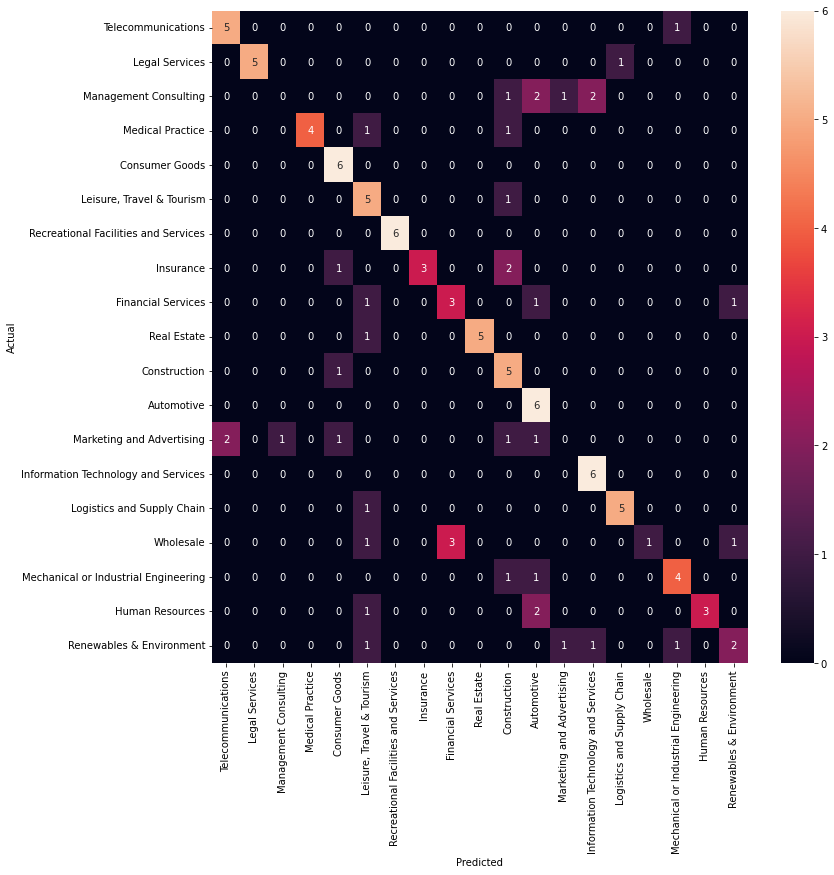

In [230]:
labels = list(di_int_to_label.values())
fig, ax = plt.subplots(figsize=(12,12)) 
cm = confusion_matrix(df_all['label'], df_all['web_pred_txt'] )
f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('cm_website.svg', bbox_inches='tight',
            dpi=300)

## Classify Combi

In [231]:
df['combi_text'] = df['gegenstand'] + ' ' + df['full_text'] 

In [232]:
df['combi_pred'] = df.progress_apply(lambda row: pipe_old(row['combi_text'])[0]['label'].replace('LABEL_',''), axis=1)
df['combi_pred'] = df['combi_pred'].astype(int)

  0%|          | 0/114 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 114/114 [00:02<00:00, 53.39it/s]


In [233]:
y_true = df['label_int']
y_pred = df['combi_pred']

accuracy = balanced_accuracy_score(y_true, y_pred)
f1_metric = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("Accuracy: {:.4f}".format(accuracy))
print("F1-score: {:.4f}".format(f1_metric))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

Accuracy: 0.7193
F1-score: 0.6860
Precision: 0.6972
Recall: 0.7193


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [234]:
df['combi_pred_txt'] = df['combi_pred'].replace(di_int_to_label)
print(classification_report(df['label'].to_list(), df['combi_pred_txt'].to_list()))

                                      precision    recall  f1-score   support

                          Automotive       0.71      0.83      0.77         6
                        Construction       0.83      0.83      0.83         6
                      Consumer Goods       0.00      0.00      0.00         6
                  Financial Services       1.00      1.00      1.00         6
                     Human Resources       0.75      1.00      0.86         6
 Information Technology and Services       0.62      0.83      0.71         6
                           Insurance       1.00      1.00      1.00         6
                      Legal Services       0.83      0.83      0.83         6
           Leisure, Travel & Tourism       0.75      0.50      0.60         6
          Logistics and Supply Chain       1.00      0.83      0.91         6
               Management Consulting       0.60      1.00      0.75         6
           Marketing and Advertising       0.55      1.00      

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


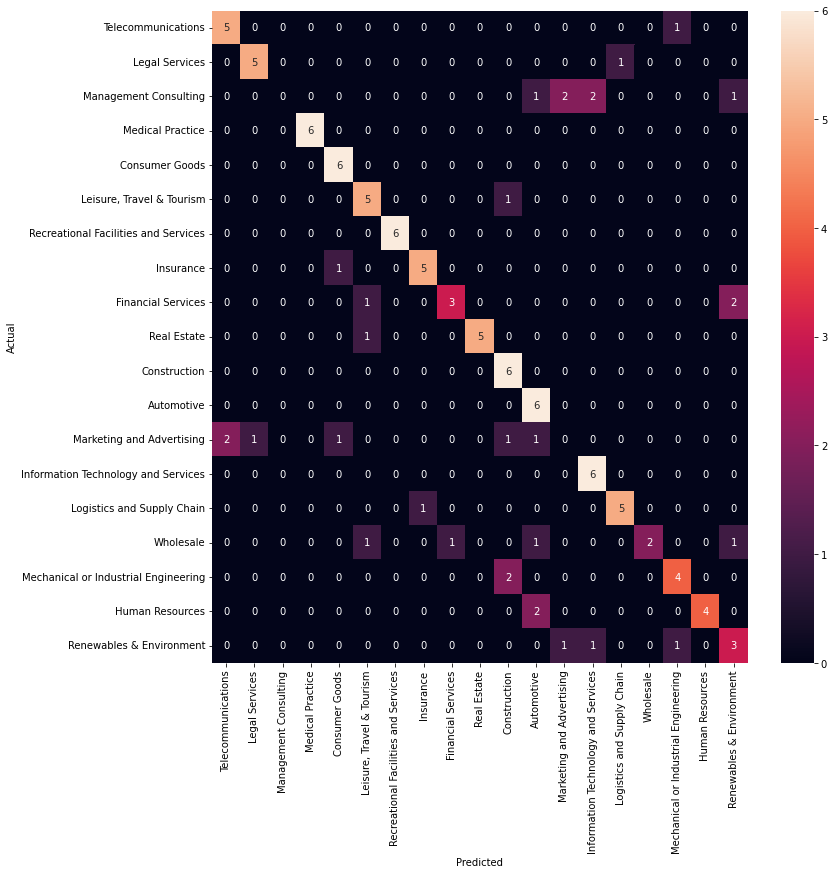

In [235]:
labels = list(di_int_to_label.values())
fig, ax = plt.subplots(figsize=(12,12)) 
cm = confusion_matrix(df_all['label'], df_all['combi_pred_txt'] )
f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('cm_combi.svg', bbox_inches='tight',
            dpi=300)

In [236]:
# # Plot Precision-Recall curve for each class and iso-f1 curves
# # von https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

# import matplotlib.pyplot as plt
# from itertools import cycle

# # setup plot details
# colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

# _, ax = plt.subplots(figsize=(7, 8))

# f_scores = np.linspace(0.2, 0.8, num=4)
# lines, labels = [], []
# for f_score in f_scores:
#     x = np.linspace(0.01, 1)
#     y = f_score * x / (2 * x - f_score)
#     (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
#     plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

# display = PrecisionRecallDisplay(
#     recall=recall["micro"],
#     precision=precision["micro"],
#     average_precision=average_precision["micro"],
# )
# display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

# for i, color in zip(range(n_classes), colors):
#     display = PrecisionRecallDisplay(
#         recall=recall[i],
#         precision=precision[i],
#         average_precision=average_precision[i],
#     )
#     display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# # add the legend for the iso-f1 curves
# handles, labels = display.ax_.get_legend_handles_labels()
# handles.extend([l])
# labels.extend(["iso-f1 curves"])
# # set the legend and the axes
# ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 1.05])
# ax.legend(handles=handles, labels=labels, loc="best")
# ax.set_title("Extension of Precision-Recall curve to multi-class")

# plt.show()

# Combine seperate Classifiers

In [237]:
# direkt argmax der W'keiten beider Classifier
# oder erst Durchschnitt der W'keiten beider Classifier bilden, dann argmax
# weitere? was sagt die Literatur?
# Trainieren separeter Modelle 
# wie können mehrer DL Modelle kombiniert werden?

# Wordcloud

Wordcloud und Transformer laufen nicht mehr im gleichen Environment

In [238]:
!pip install -U pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.3.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.0.0
    Uninstalling Pillow-9.0.0:
      Successfully uninstalled Pillow-9.0.0
